## Import

### Run it in case of using Colab servers

In [1]:
import os, sys, inspect, time
"""
solve the conflict between paths, and work dir
"""
sys.path.append('../')
os.chdir('../')
print(sys.path)
print(os.getcwd())

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import lfi
from lfi.utils import discrepancy, visualization
from lfi.algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from lfi.detsimul import problem_GC
from lfi.utils import uos, umath

#%load_ext autoreload
#%autoreload 2

['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '../']
/


ModuleNotFoundError: No module named 'lfi'

## Problem Definition

visualizing p(x|theta)


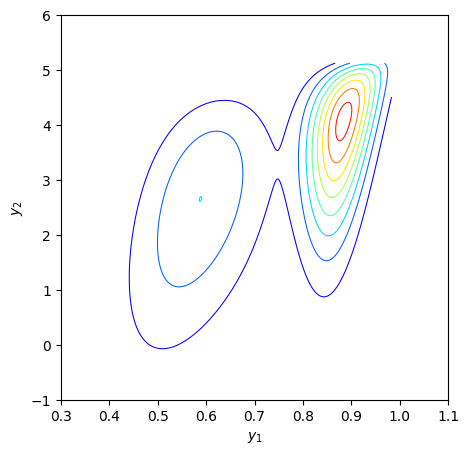

mean-parma1 =  6.744596158104399      mean-param2 =  0.4528722361855515


<Figure size 500x400 with 0 Axes>

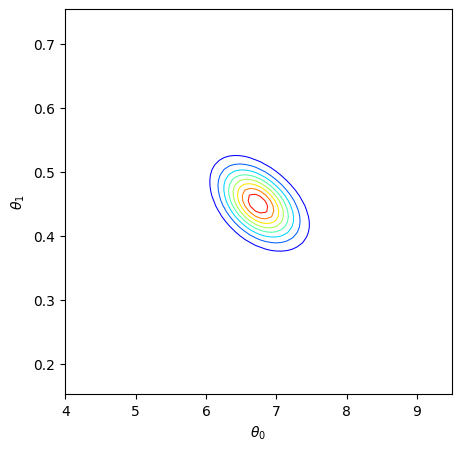

In [2]:
DIR = 'results/FFD'                                             
RERUN = not uos.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_GC.Gaussian_Copula_Problem(N=500, n=20)
problem.stat = 'raw_single'
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed stat
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    uos.save_object(DIR, 'data_obs', problem.data_obs)
    uos.save_object(DIR, 'y_obs', problem.y_obs)
    
    # collect samples
    true_samples = problem.sample_from_true_posterior() # Sample theta ~ p(theta|x_o)
    uos.save_object(DIR, 'true_samples', true_samples)
else:
    true_samples = uos.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = uos.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = uos.load_object(DIR, 'y_obs.npy')
    
## Visualize the problem
problem.visualize()
visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(1,2))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,2))
plt.figure(figsize=(5,4))
visualization.plot_samples(problem.data_obs)

## Inference

### SMC

iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  100
[sampling] finished sampling  200
[sampling] finished sampling  300
[sampling] finished sampling  400
> learning fake posterior 
> learning true posterior 


iteration  1
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  100
[sampling] finished sampling  200
[sampling] finished sampling  300
[sampling] finished sampling  400
> learning fake posterior 
fitting Gaussian copula progress= 0.0 loss= 2933.58447265625
fitting Gaussian copula progress= 0.1 loss= 1367.1312255859375
fitting Gaussian copula progress= 0.2 loss= 851.5970458984375
fitting Gaussian copula progress= 0.3 loss= 549.77294921875
fitting Gaussian copula progress= 0.4 loss= 481.9645080566406
fitting Gaussian copula progress= 0.5 loss= 452.17999267578125
fitting Gaussian c

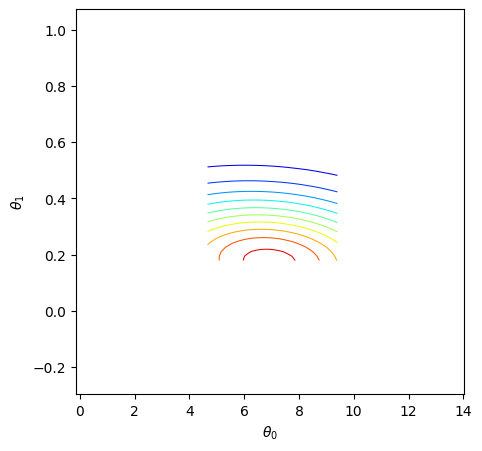

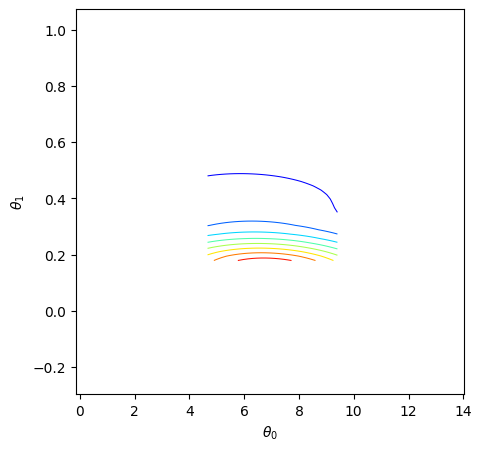

In [3]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
#hyperparams.device = 'cpu'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 2                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
uos.save_object(DIR, 'JSD_SMC', JSD_smc_array)

In [ ]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 2                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'JSD'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
uos.save_object(DIR, 'JSD_SMC2', JSD_smc2_array)

### SNL

In [4]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
#hyperparams.device = 'cuda:1'
hyperparams.device = 'cpu'
hyperparams.num_sim = 4000
hyperparams.L = 2

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
uos.save_object(DIR, 'JSD_SNL', JSD_array)


 SNL ABC
iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  100
[sampling] finished sampling  200
[sampling] finished sampling  300
[sampling] finished sampling  400
finished: t= 0 loss= 214.04019165039062 loss val= 212.46087646484375 best loss 212.46087646484375


KeyboardInterrupt: 

iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start![ABC] sub-process start!

[ABC] sub-process start!
[sampling] finished sampling  100
[sampling] finished sampling  200
[sampling] finished sampling  300
[sampling] finished sampling  400

 > fitting encoder
summary statistic dim = 6 original dim = 41
architecture [41, 100, 100, 6]
finished: t= 0 loss= -0.26630380749702454 loss val= -0.2921587824821472 best loss -0.2921587824821472
finished: t= 200 loss= -0.9982023239135742 loss val= -0.9975641965866089 best loss -0.9976531863212585
finished: t= 400 loss= -0.9981241822242737 loss val= -0.9975976943969727 best loss -0.9976917505264282
finished: t= 600 loss= -0.9971325397491455 loss val= -0.9975146055221558 best loss -0.9976930618286133
finished: t= 800 loss= -0.9986088275909424 loss val= -0.9973752498626709 best loss -0.9976930618286133
finished: t= 1000 loss= -0.9983579516410828 loss val= -0.997315526008606 best loss -0.9976930618286133
finished: t= 1200 loss= 

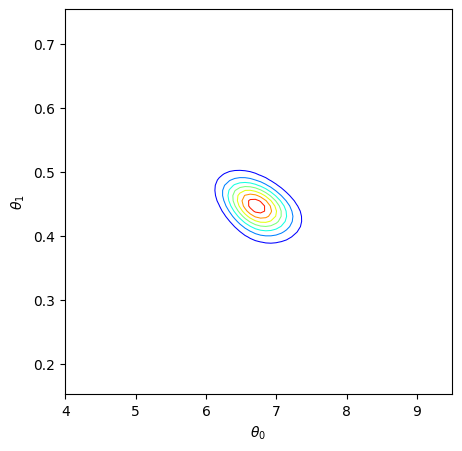

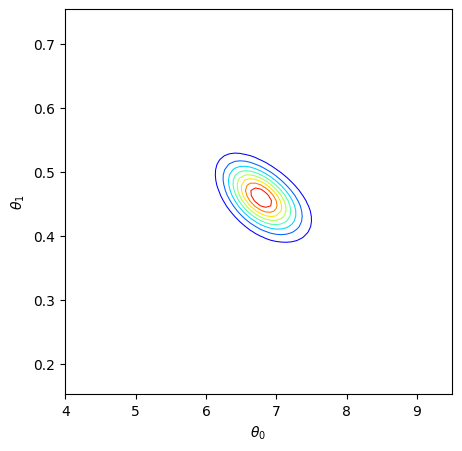

In [3]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
#hyperparams.device = 'cpu'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.L = 2                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'DC'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    # Plot P vs (theta_0,theta_1)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    # Plot P vs (theta_1,theta_2)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(1,2))
    # Plot P vs (theta_0,theta_2)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,2))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
uos.save_object(DIR, 'JSD_SNL2', JSD_array)